# CCT20 Exploratory Data Analysis

### Imports and Dataset Download


In [2]:
import random
import numpy as np
import cv2
import os
import json
import math
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, WeightedRandomSampler


For the CCT20 annotations, it was used for training, and therefore for this EDA, the train_annotations and trans_test_annotations.json. This was due to the fact that the train_annotations is much smaller than the cis_test_annotations.json. So to make the train set larger it was used the two annotation files.

There's a space for the path of your downloaded benchmark images and annotations.

In [ ]:
# Paths
annotations_folder_train = r""
image_folder = r""

# List of the specific annotation files to load
json_files = ["train_annotations.json", "trans_test_annotations.json"]

# Store data
image_data = []
annotations_data = []
category_mapping = {}

# Load JSON files
for file in json_files:
    file_path = os.path.join(annotations_folder_train, file)
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Store category mappings
    for category in data['categories']:
        category_mapping[category['id']] = category['name']

    # Store image data with correct ID mapping
    img_id_to_filename = {}
    for img in data['images']:
        img_id_to_filename[img['id']] = img['file_name']
        image_data.append({
            'image_id': img['file_name'],  # Ensure we store filenames, not UUIDs
            'width': img['width'],
            'height': img['height']
        })
    
    # Store annotations with corrected ID
    for ann in data['annotations']:
        if ann['image_id'] in img_id_to_filename:
            annotations_data.append({
                'image_id': img_id_to_filename[ann['image_id']],  # Convert UUID to filename
                'category_id': ann['category_id'],
                'category_name': category_mapping[ann['category_id']],
                'bbox': ann.get('bbox', None)
            })

# Convert to DataFrames
image_df = pd.DataFrame(image_data)
annotation_df = pd.DataFrame(annotations_data)

# Merge on the corrected 'image_id'
train_df = annotation_df.merge(image_df, on="image_id", how="inner")

# Check data
print("Dataset size:", train_df.shape)
print(train_df.head())

Dataset size: (38099, 6)
                                   image_id  category_id category_name  \
0  5a197af2-23d2-11e8-a6a3-ec086b02610b.jpg           10        rabbit   
1  59fc7e52-23d2-11e8-a6a3-ec086b02610b.jpg           16           cat   
2  5a2e130d-23d2-11e8-a6a3-ec086b02610b.jpg           10        rabbit   
3  598ad0cf-23d2-11e8-a6a3-ec086b02610b.jpg            8           dog   
4  598ad0cf-23d2-11e8-a6a3-ec086b02610b.jpg            8           dog   

                                                bbox  width  height  
0  [317.44, 747.52, 261.11999999999995, 284.15999...   2048    1494  
1           [0.0, 660.48, 381.44, 273.9200000000001]   2048    1494  
2                    [1397.76, 458.24, 192.0, 192.0]   2048    1494  
3  [989.44, 759.04, 262.4000000000001, 390.400000...   2048    1494  
4       [33.28, 1118.72, 583.68, 375.03999999999996]   2048    1494  


## Dataset Introduction

### Caltech Camera Traps

This data set contains 243,100 images from 140 camera locations in the Southwestern United States, with labels for 21 animal categories (plus empty), primarily at the species level (for example, the most common labels are opossum, raccoon, and coyote), and approximately 66,000 bounding box annotations. Approximately 70% of images are labeled as empty.

### CCT20 Benchmark subset

Caltech Camera Traps-20 (CCT-20), was introduced in Beery et al. 2018. This subset consists of 57,868 images captured from 20 camera trap locations, downsized to a maximum resolution of 1024 pixels on one side. The dataset includes 15 classes, some of which represent single species (e.g., "Coyote") while others represent groups of species (e.g., "Bird"). This subset can be found at https://lila.science/datasets/caltech-camera-traps

In this section, we begin by confirming the dataset size and distribution. The dataset is highly imbalanced, with opossums dominating (~14,000 images), followed by raccoons and coyotes, while foxes, badgers, and deer are significantly underrepresented. The "Empty" class also contains a notable number of images (~4,000).

A visual inspection of the images was performed using a function that displays 10 random samples along with their labels and another where it displays one random image per category. Running this function multiple times provides a better understanding of the dataset and allows for an initial assessment of color imbalances, object shape variations, and other characteristics. 
Many images captured at night have low contrast, making object detection more difficult. Motion blur is also present, particularly in nocturnal images. 
Fast-moving objects, such as cars, are often only partially visible, typically showing just the wheels or part of the body. Similarly, deer frequently appear with only their faces visible, which complicates training when distinguishing between naturally captured and posed animals.

In [20]:
train_df['category_name'].unique()

array(['rabbit', 'cat', 'dog', 'opossum', 'squirrel', 'raccoon', 'coyote',
       'rodent', 'bird', 'bobcat', 'skunk', 'badger', 'car', 'fox',
       'deer', 'empty'], dtype=object)

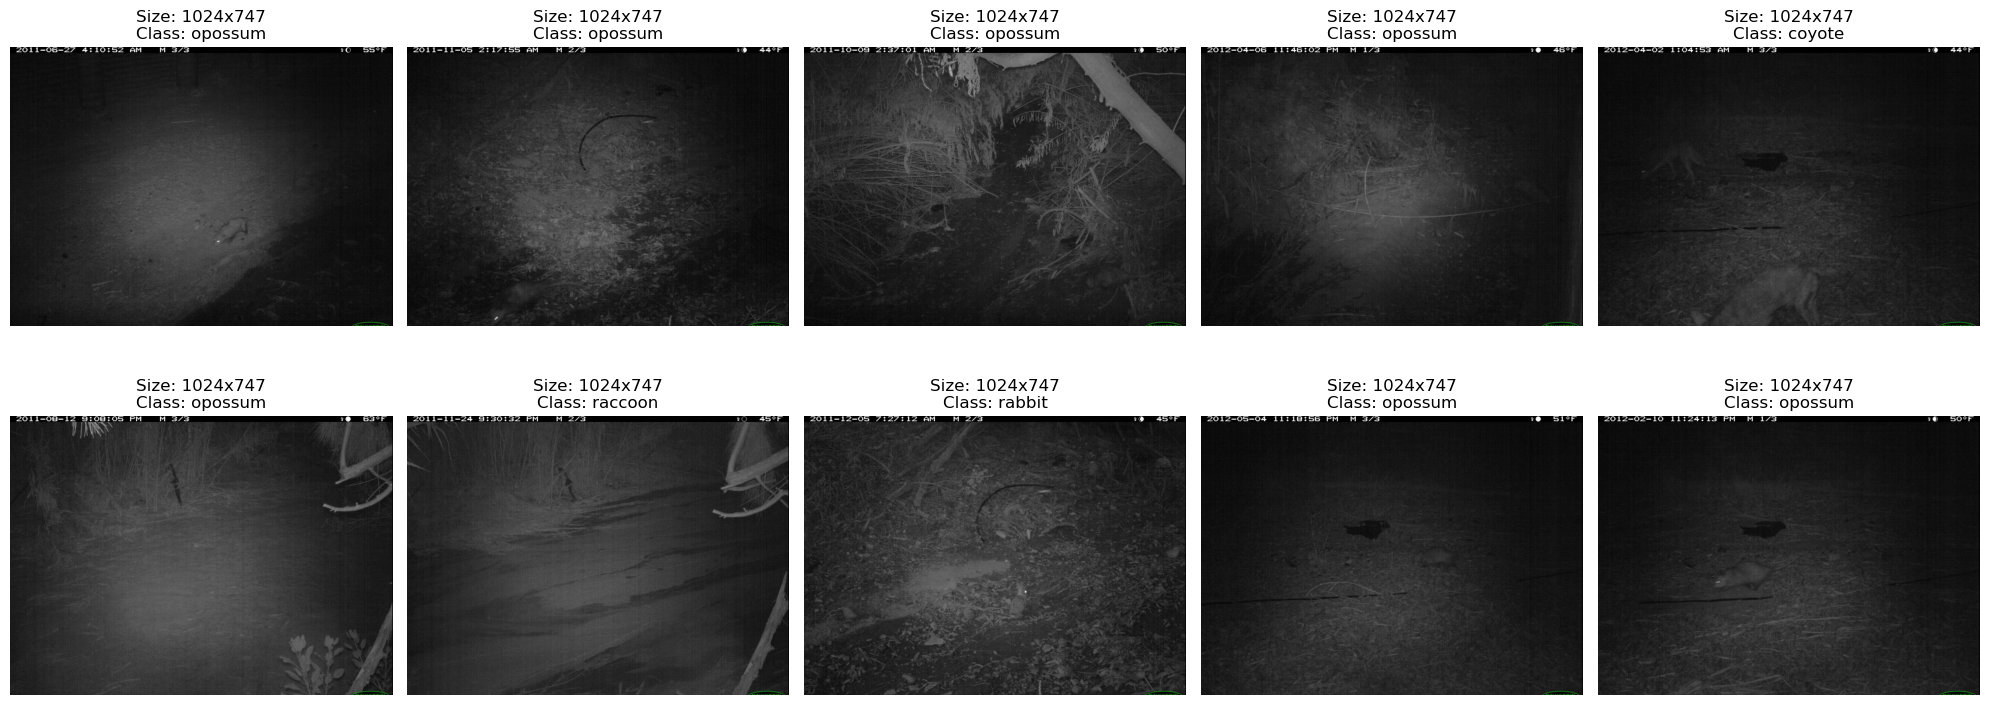

In [4]:
# Ensure there are enough samples in the dataset
num_samples = min(10, len(train_df))  # Get the minimum of 10 or available samples

# Step 1: Randomly select the samples
random_samples = train_df.sample(n=num_samples)

# Step 2: Adjust subplot layout based on the number of samples
cols = 5
rows = (num_samples + cols - 1) // cols  # Calculate required rows to fit the number of samples

# Set up the plot with a dynamic grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))

# Flatten axes for easier iteration, and handle cases where the number of axes is less than samples
axes = axes.flatten()

# Step 3: Loop through the random samples, load images, and plot them
for i, row in enumerate(random_samples.itertuples()):
    img_path = os.path.join(image_folder, row.image_id)  # Update the folder path
    img = Image.open(img_path)
    
    # Display the image and its size
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Size: {img.size[0]}x{img.size[1]}\nClass: {row.category_name}")

# Hide unused axes if there are fewer than 10 samples
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Step 4: Show the plot
plt.tight_layout()
plt.show()


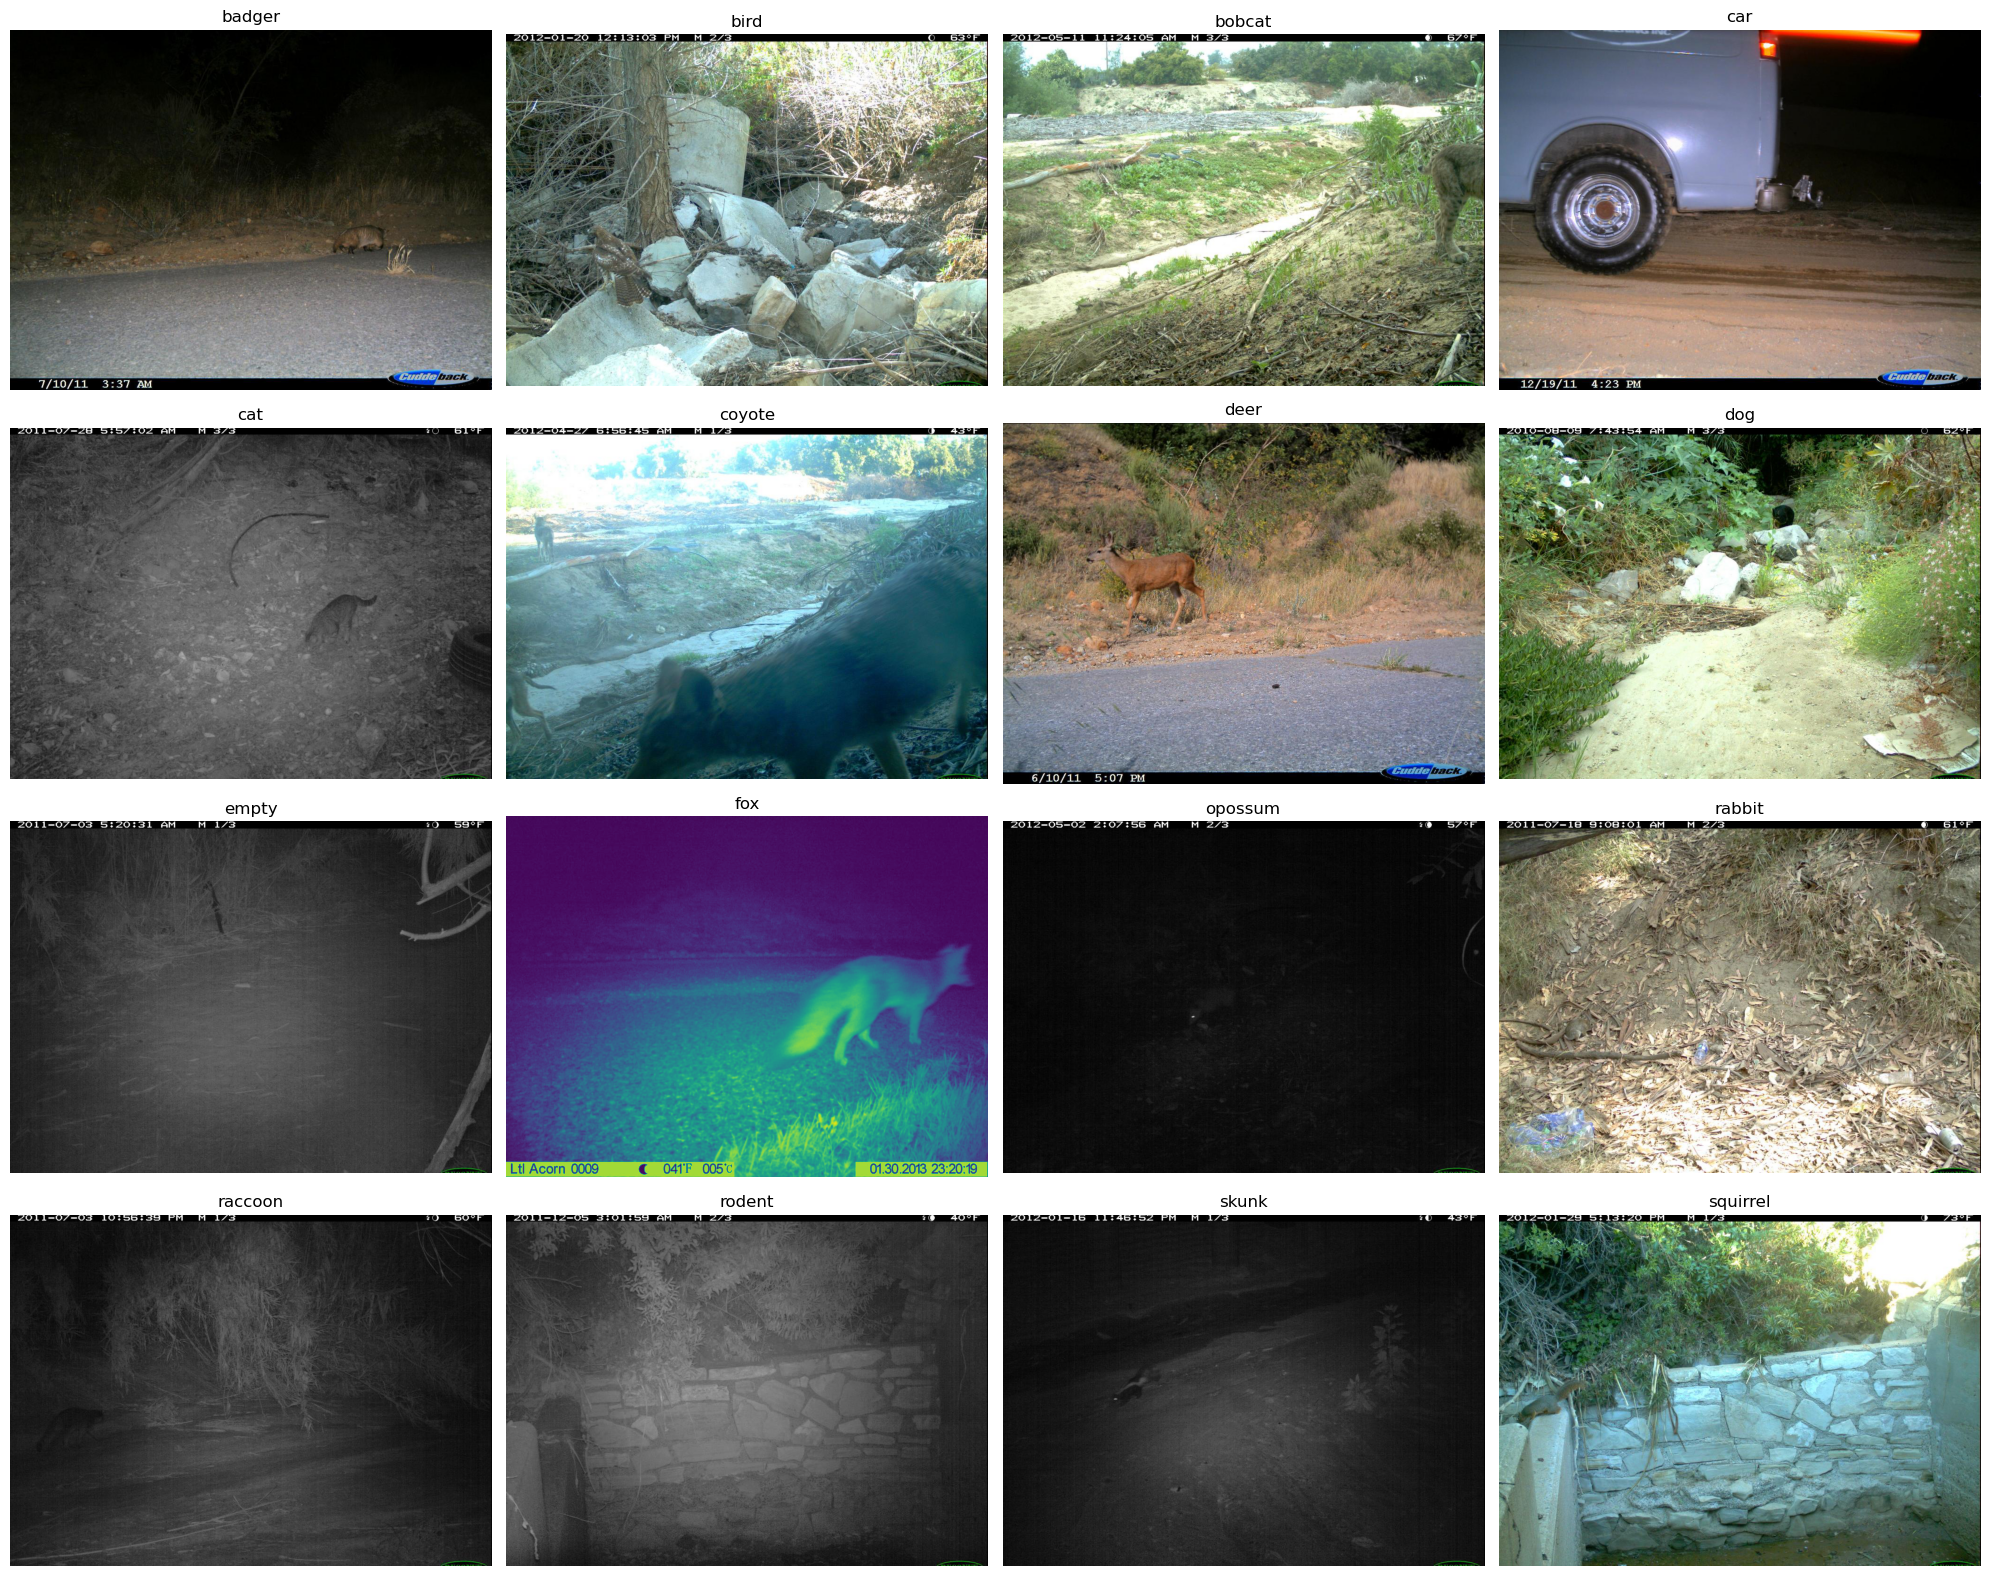

In [20]:
# One random image per category
unique_classes = train_df['category_name'].unique()  # Get all unique classes

# Step 1: Randomly select one sample per class
random_samples = train_df.groupby('category_name').sample(n=1, random_state=42)  # Select one image per class

# Step 2: Adjust subplot layout based on the number of unique classes
num_samples = len(random_samples)
cols = 4
rows = (num_samples + cols - 1) // cols  # Calculate required rows

# Set up the plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()  # Flatten for easy iteration

# Step 3: Loop through selected samples, load images, and plot them
for i, row in enumerate(random_samples.itertuples()):
    img_path = os.path.join(image_folder, row.image_id)  # Update the folder path
    img = Image.open(img_path)

    # Display image with class label
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{row.category_name}")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


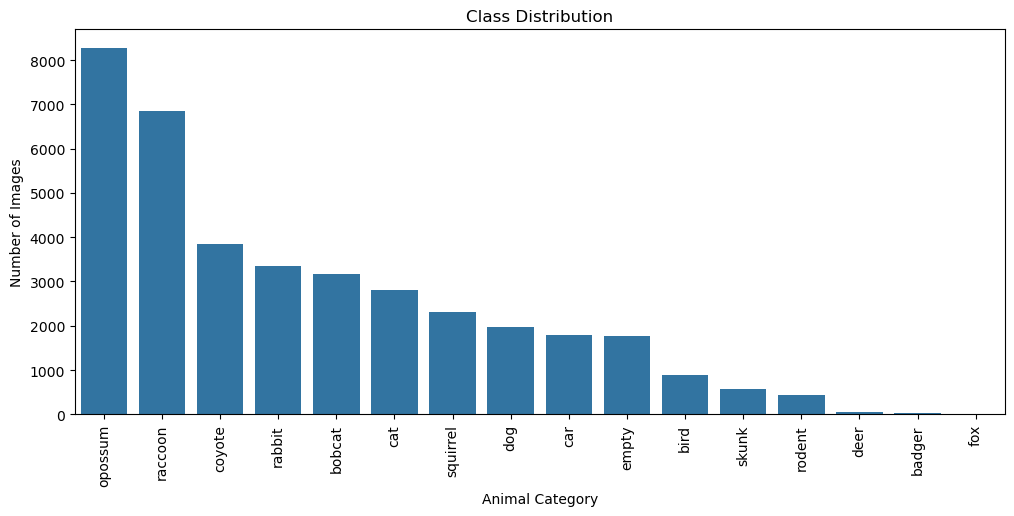

In [22]:
# Count occurrences of each category
category_counts = train_df['category_name'].value_counts()

# Plot category distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Animal Category")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

### RGB Variance Analysis

To assess the variation in color distribution, the RGB variance was calculated for each class. In theory, low RGB variance suggests that most images within a class share a similar color palette, which may indicate a common background. This is particularly relevant in a dataset where animals are photographed in natural environments. 

For example, birds and deer exhibited slightly higher green variance, reflecting their predominantly forested surroundings. Similary, opossums and raccoons, which are often photographed at night, had lower RGB variance due to the darker backgrounds typical of nocturnal captures. The car class displayed a greyish mean color, aligning with the fact that vehicles in the dataset are commonly grey

In [ ]:
# Parameters for chunk processing
chunk_size = 1000  # Number of images to process at a time

# Dictionary to store RGB values per class
rgb_values = {class_name: [] for class_name in train_df['category_name'].unique()}

# Process dataset in chunks
for i in range(0, len(train_df), chunk_size):
    chunk_df = train_df.iloc[i : i + chunk_size]  # Get a chunk of data
    
    for _, row in chunk_df.iterrows():
        img_path = os.path.join(image_folder, row['image_id'])

        try:
            img = Image.open(img_path).convert("RGB")  # Load image

            # Convert image to NumPy array and normalize values (0 to 1 range)
            img_array = np.array(img) / 255.0

            # Compute mean RGB values
            mean_rgb = img_array.reshape(-1, 3).mean(axis=0)

            # Store values in corresponding class list
            rgb_values[row['category_name']].append(mean_rgb)
        
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Compute variance per class
class_variances = {class_name: np.var(values, axis=0) for class_name, values in rgb_values.items()}

# Convert to DataFrame for visualization
variance_df = pd.DataFrame.from_dict(class_variances, orient='index', columns=['R', 'G', 'B'])
variance_df.reset_index(inplace=True)
variance_df.rename(columns={'index': 'Class'}, inplace=True)

# Display the computed variance values
print(variance_df)

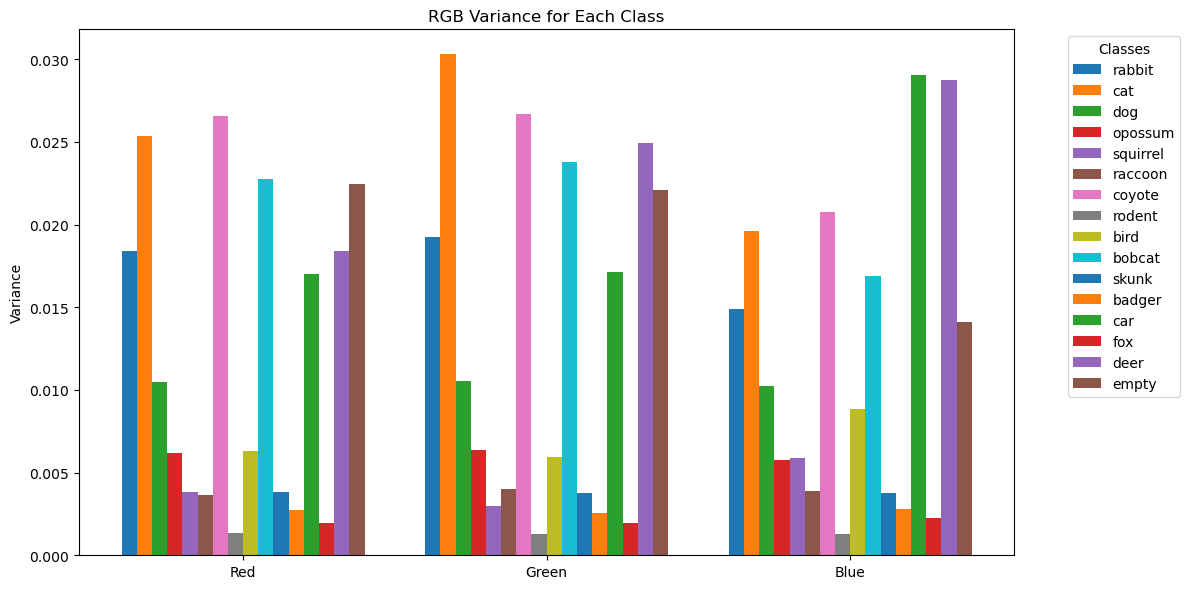

In [34]:
#Plot the Variance of RGB Values per Class
rgb_channels = ['Red', 'Green', 'Blue']
x = np.arange(len(rgb_channels))  # Positions for R, G, B bars
width = 0.05  # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each class
for i, (class_name, variance) in enumerate(class_variances.items()):
    ax.bar(x + i * width, variance, width, label=class_name)

# Adjust X-axis labels
ax.set_xticks(x + (len(class_variances) * width) / 2 - width / 2)
ax.set_xticklabels(rgb_channels)
ax.set_ylabel('Variance')
ax.set_title('RGB Variance for Each Class')

# Add legend
ax.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

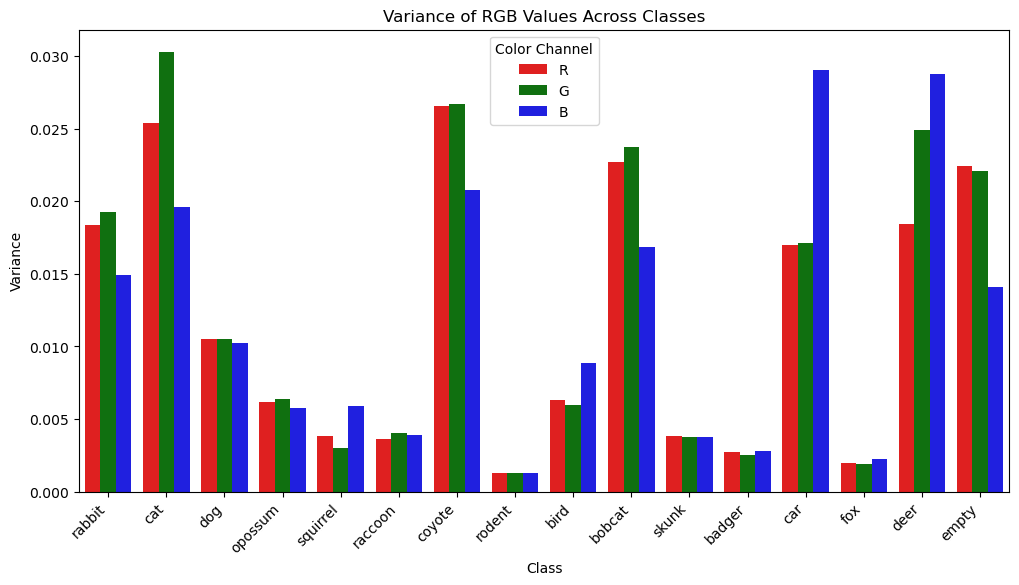

In [24]:
# Melt the dataframe for easier plotting
variance_df_melted = variance_df.melt(id_vars=['Class'], var_name='Channel', value_name='Variance')

# Plot RGB variance per class
plt.figure(figsize=(12, 6))
sns.barplot(data=variance_df_melted, x='Class', y='Variance', hue='Channel', palette=['red', 'green', 'blue'])

# Improve readability
plt.xticks(rotation=45, ha='right')
plt.title('Variance of RGB Values Across Classes')
plt.ylabel('Variance')
plt.xlabel('Class')
plt.legend(title='Color Channel')

# Show the plot
plt.show()


In [44]:
class CCT20Dataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image metadata.
            image_folder (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

        # Create a mapping from category names to indices
        self.classes = dataframe['category_name'].unique().tolist()
        self.class_to_idx = {category: idx for idx, category in enumerate(self.dataframe['category_name'].unique())}
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the sample row
        sample = self.dataframe.iloc[idx]
        img_name = os.path.join(self.image_folder, sample['image_id'])
        # Open image and convert to RGB to ensure 3 channels
        img = Image.open(img_name).convert("RGB")
        
        # Apply transformations (e.g., ToTensor, Normalize, etc.)
        if self.transform:
            img = self.transform(img)
        
        # Convert category name to integer index
        label = self.class_to_idx[sample['category_name']] 
        
        # Return the image and the label
        return img, torch.tensor(label, dtype=torch.long)

# Define transformations (for example, ToTensor and normalization)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Optional: Resize the images to a consistent size
    transforms.ToTensor(),  # Convert image to tensor
])

# Use the dataframe you created earlier
train_set = CCT20Dataset(dataframe=train_df, image_folder=image_folder, transform=transform)

### Underexposed Images

Lighting conditions in camera trap datasets vary, leading to underexposed (dark) and overexposed (bright) images. To assess this, images were classified based on their RGB values: those with a combined RGB sum below 60 were labeled as "black," while those exceeding 220 were considered "white."

Processing the dataset revealed 238 underexposed images and 0 overexposed images, confirming that darkness is a more significant issue. The majority of black images were found in nocturnal species like opossums and cats. This imbalance can affect model performance, as dark images obscure important features.

Processing images 0 to 1000...
Processing images 1000 to 2000...
Processing images 2000 to 3000...
Processing images 3000 to 4000...
Processing images 4000 to 5000...
Processing images 5000 to 6000...
Processing images 6000 to 7000...
Processing images 7000 to 8000...
Processing images 8000 to 9000...
Processing images 9000 to 10000...
Processing images 10000 to 11000...
Processing images 11000 to 12000...
Processing images 12000 to 13000...
Processing images 13000 to 14000...
Processing images 14000 to 15000...
Processing images 15000 to 16000...
Processing images 16000 to 17000...
Processing images 17000 to 18000...
Processing images 18000 to 19000...
Processing images 19000 to 20000...
Processing images 20000 to 21000...
Processing images 21000 to 22000...
Processing images 22000 to 23000...
Processing images 23000 to 24000...
Processing images 24000 to 25000...
Processing images 25000 to 26000...
Processing images 26000 to 27000...
Processing images 27000 to 28000...
Processing ima

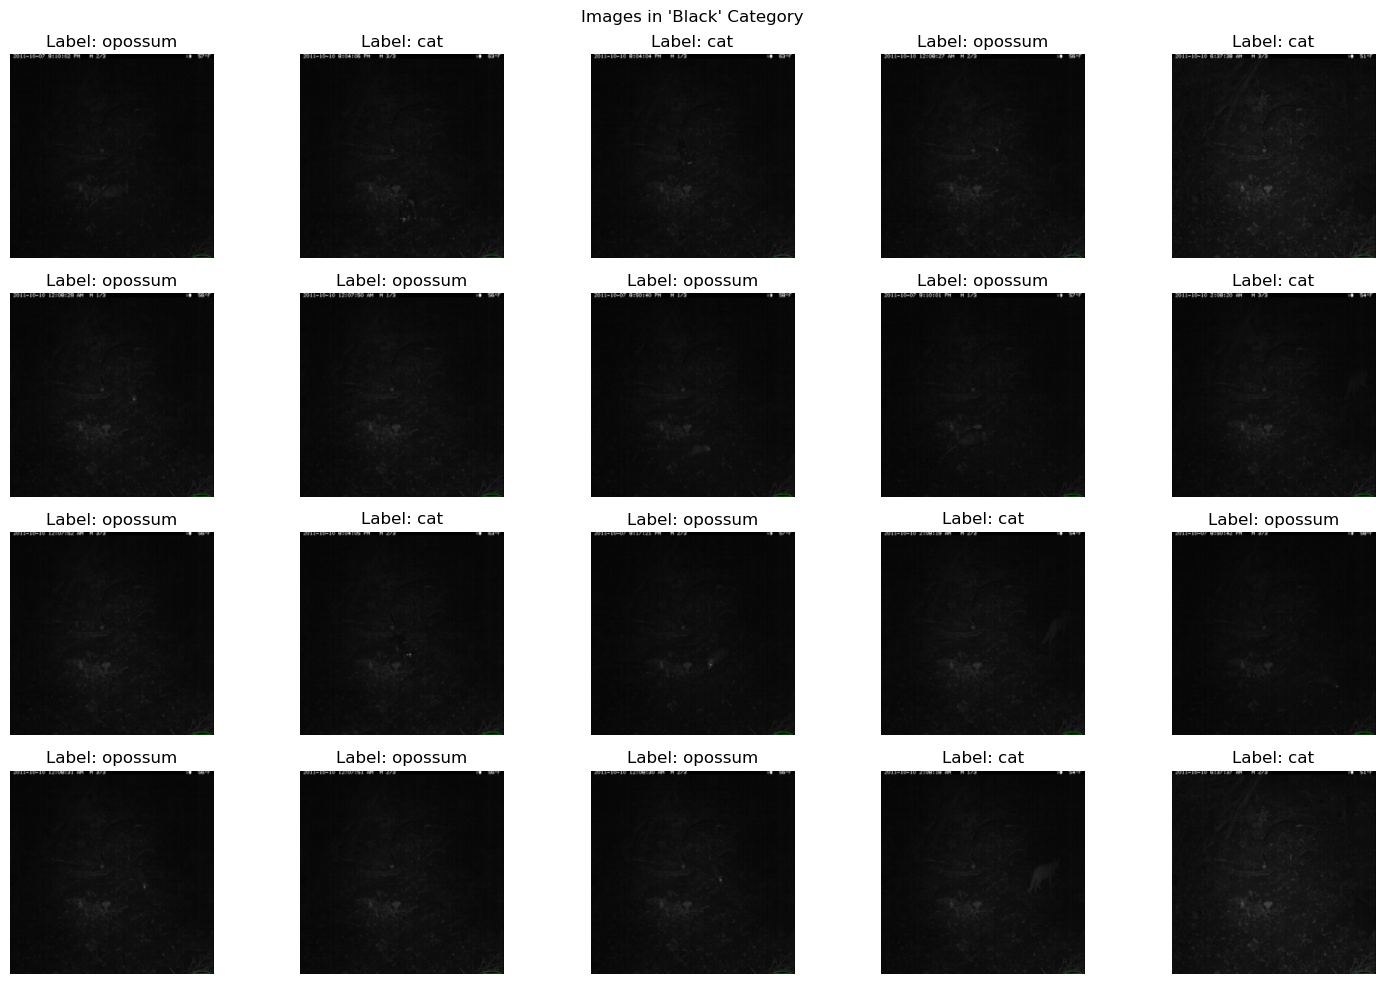


Black Image Counts per Class:
  opossum    => 1
  cat        => 1
  cat        => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  opossum    => 1
  cat        => 1
  opossum    => 1
  opossum    =>

In [35]:
# Function to classify images as black or white
def is_black_or_white(r, g, b):
    if r + g + b < 60:  # Very dark images
        return "black"
    if r > 220 and g > 220 and b > 220:  # Very bright images
        return "white"
    return None

# Define chunk size to avoid memory overload
chunk_size = 1000  

# Store results for black and white images
black_images, white_images = [], []
black_labels, white_labels = [], []

# Process dataset in chunks
for chunk_start in range(0, len(train_set), chunk_size):
    chunk_end = min(chunk_start + chunk_size, len(train_set))
    print(f"Processing images {chunk_start} to {chunk_end}...")

    for i in range(chunk_start, chunk_end):
        img_tensor, label = train_set[i]

        # Convert image tensor to 0-255 scale
        img_255 = img_tensor * 255

        # Mask to exclude completely black areas (background pixels)
        non_black_mask = img_255.sum(dim=0) > 0
        valid_pixels = img_255[:, non_black_mask]

        if valid_pixels.numel() == 0:
            black_images.append(img_tensor)
            black_labels.append(label)
            continue

        # Compute mean color ignoring black background
        mean_color_tensor = valid_pixels.mean(dim=1)
        r, g, b = mean_color_tensor.int().tolist()

        # Categorize image
        category = is_black_or_white(r, g, b)
        if category == "black":
            black_images.append(img_tensor)
            black_labels.append(label)
        elif category == "white":
            white_images.append(img_tensor)
            white_labels.append(label)

# Count black and white images per class
black_class_counts = Counter(black_labels)
white_class_counts = Counter(white_labels)

# Print results
print(f"Found {len(black_images)} black images and {len(white_images)} white images.\n")

# Show black images
if black_images:
    print("Sample Black Images:")
    plt.figure(figsize=(15, 10))
    for idx, img in enumerate(black_images[:20]):
        ax = plt.subplot(4, 5, idx + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Label: {train_set.classes[black_labels[idx]]}")
        plt.axis("off")
    plt.suptitle("Images in 'Black' Category")
    plt.tight_layout()
    plt.show()

# Show white images
if white_images:
    print("Sample White Images:")
    plt.figure(figsize=(15, 10))
    for idx, img in enumerate(white_images[:20]):
        ax = plt.subplot(4, 5, idx + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Label: {train_set.classes[white_labels[idx]]}")
        plt.axis("off")
    plt.suptitle("Images in 'White' Category")
    plt.tight_layout()
    plt.show()

# Print per-class counts
print("\nBlack Image Counts per Class:")
for class_idx, count in black_class_counts.items():
    print(f"  {train_set.classes[class_idx]:<10} => {count}")

print("\nWhite Image Counts per Class:")
for class_idx, count in white_class_counts.items():
    print(f"  {train_set.classes[class_idx]:<10} => {count}")

### Mean color, Mean Images and Eigenimages per class

The average image was calculated for each class to provide insight into overall color trends, the space occupied by subjects, and common background characteristics. Although this technique is less informative for datasets with high intra-class variation, it helps visualize general trends. Deer and birds, for instance, showed a slightly greenish tint, likely due to the prevalence of forested settings. Nocturnal animals such as raccoons and opossums had darker mean images, while the car class exhibited a predominantly grey hue.

Next, eigenimages were generated for each class to highlight key visual patterns. The process involved flattening images into a 3072-value vector (32×32×3) and applying Principal Component Analysis (PCA) to reduce dimensionality. The first principal component was then reshaped back into an image, revealing the most significant visual features for each class. This approach helps in understanding the dominant structures and textures in the dataset, even if individual images vary significantly.


In [ ]:
# Compute average RGB values per class
class_avg_colors = {class_name: np.mean(values, axis=0) for class_name, values in rgb_values.items()}

# Convert values to 0-255 range for visualization
class_avg_colors = {class_name: (color * 255).astype(int) for class_name, color in class_avg_colors.items()}

# Plot color swatches
fig, ax = plt.subplots(1, len(class_avg_colors), figsize=(10, 3))

for i, (class_name, color) in enumerate(class_avg_colors.items()):
    ax[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=np.array(color) / 255.0))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(class_name, fontsize=10)

plt.suptitle("Average Color of Each Class", fontsize=10)
plt.show()

NameError: name 'rgb_values' is not defined

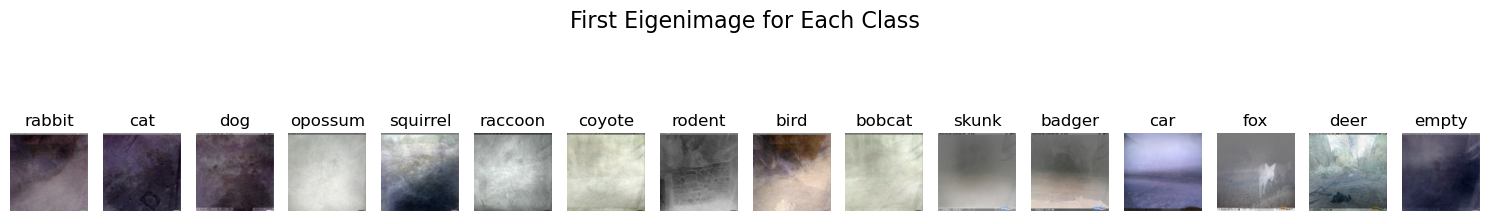

In [30]:
# Resize settings
TARGET_SIZE = (224, 224)  # Resizing images for PCA

def load_and_resize_image(image_path, target_size=TARGET_SIZE):
    """Loads an image, resizes it, and converts it to a NumPy array."""
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure RGB format
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def eigen_img(dataset, image_folder, n_components=5):
    """
    Computes and plots the first eigenimage for each class using PCA.
    Resizes images before processing.
    """
    eigenimages = []
    class_names = dataset['category_name'].unique()

    for class_name in class_names:
        class_images = dataset[dataset['category_name'] == class_name]['image_id']
        
        images_list = []
        for img_id in class_images:
            img_path = os.path.join(image_folder, img_id)
            img_array = load_and_resize_image(img_path)
            if img_array is not None:
                images_list.append(img_array)
        
        if len(images_list) == 0:
            print(f"Skipping {class_name} (no valid images).")
            continue
        
        # Convert to NumPy array
        class_images_array = np.array(images_list)  
        n_samples, height, width, channels = class_images_array.shape

        # Flatten images for PCA
        class_images_flat = class_images_array.reshape(n_samples, -1)

        # Perform PCA
        pca = PCA(n_components=n_components)
        pca.fit(class_images_flat)

        # Extract first principal component (eigenimage)
        eigenvector = pca.components_[0].reshape(height, width, channels)

        # Normalize eigenimage for display
        eigenvector_min = eigenvector.min()
        eigenvector_max = eigenvector.max()
        eigenimage_normalized = 255 * (eigenvector - eigenvector_min) / (eigenvector_max - eigenvector_min)
        
        eigenimages.append((class_name, eigenimage_normalized))

    # Plot results
    fig, axes = plt.subplots(1, len(eigenimages), figsize=(15, 3))

    for ax, (class_name, eigenimage) in zip(axes, eigenimages):
        ax.imshow(eigenimage.astype('uint8'))
        ax.axis('off')
        ax.set_title(class_name)

    plt.suptitle('First Eigenimage for Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
eigen_img(train_df, image_folder)


In [45]:
# Calculate class frequencies in the training set
class_counts = train_df['category_name'].value_counts()

# Compute class weights relative to the most frequent class
max_count = max(class_counts)  
class_weights = {cls: max_count / count for cls, count in class_counts.items()}

# Assign weights to each sample in the dataset
sample_weights = train_df['category_name'].map(class_weights).values
sample_weights = torch.DoubleTensor(sample_weights)

# Create a WeightedRandomSampler with adjusted weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create the DataLoader using the new sampler
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)

## Object Contouring and Area Detection

To analyze the size and positioning of subjects, object contouring was performed using OpenCV. A function was created to plot 10 random images with detected contours, allowing for verification of contour accuracy. Afterward, the average area occupied by each category’s subjects was calculated to compare the relative space taken up within the frame.

Histograms of subject sizes were plotted to ensure an even spread of object sizes within each class. This step is important because if a class consistently contains subjects of the same size, it may lead to model overfitting. Subject area detection also revealed inconsistencies in how animals appear in the images. Some species were more difficult to detect due to occlusion, motion blur, or poor illumination. Larger animals, such as deer, were often only partially visible in the frame, reducing consistency in subject area measurements.

By addressing these dataset characteristics and challenges, we gain a better understanding of potential biases, class imbalances, and image quality variations, all of which are crucial considerations for model training and evaluation.

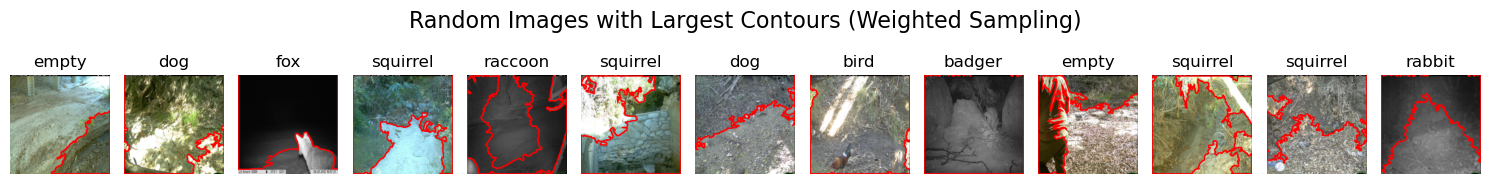

In [26]:
# Create a mapping from index to class name
idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}

# Function to visualize sampled images with contours from the DataLoader
def plot_contours_from_loader(data_loader, num_images=13):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))

    # Get a batch from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)  # Extract a batch
    
    # Convert tensors to numpy arrays and plot
    for i in range(num_images):
        img = images[i]
        label = labels[i].item()  # Convert tensor to integer
        
        img_np = np.transpose(img.numpy(), (1, 2, 0))  # Convert from tensor to numpy (HWC format)
        gray = cv2.cvtColor((img_np * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian blur
        _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Thresholding

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)  # Find the largest contour
            img_with_contour = cv2.drawContours(img_np.copy(), [largest_contour], -1, (1, 0, 0), 2)  # Draw contour
        else:
            img_with_contour = img_np  # No contours, show original image

        axes[i].imshow(img_with_contour)  # Plot the image with contour
        axes[i].axis('off')  # Remove axes
        axes[i].set_title(idx_to_class[label])  # Convert label index to class name
    
    plt.suptitle("Random Images with Largest Contours (Weighted Sampling)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function to display images with contours from the weighted train_loader
plot_contours_from_loader(train_loader, num_images=13)

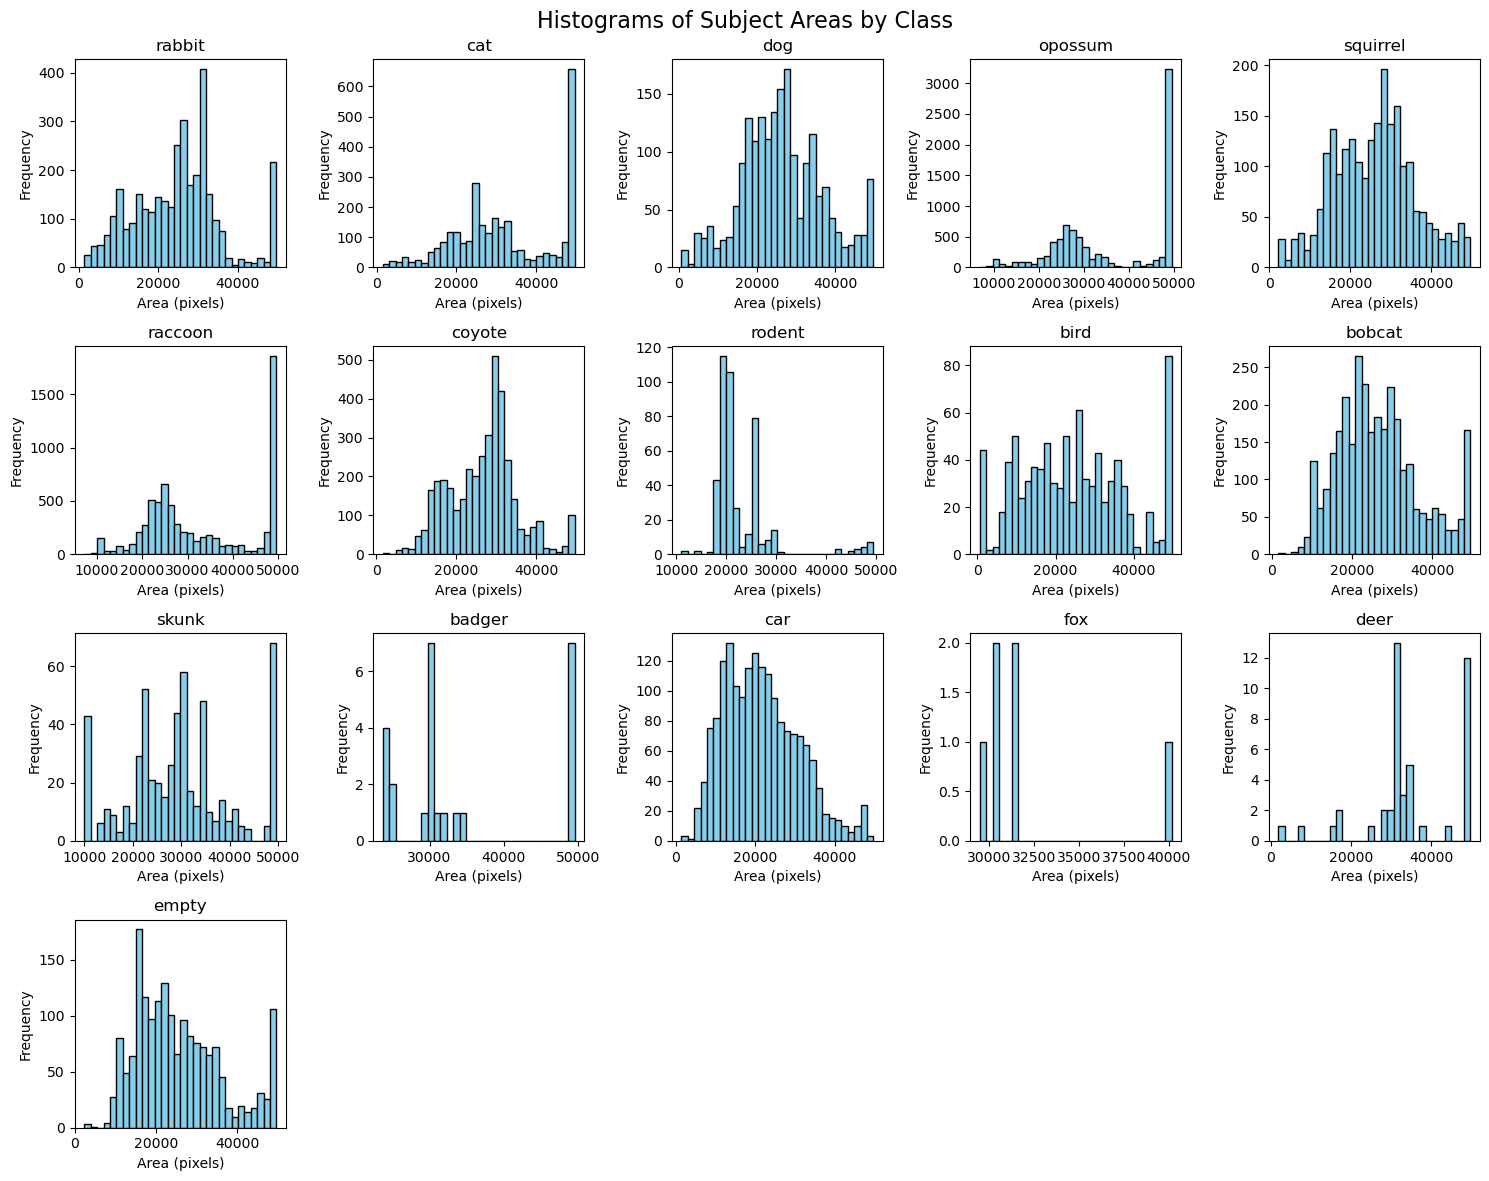

Avg area occupied by 'rabbit': 24872.23 pixels
Avg area occupied by 'cat': 32001.47 pixels
Avg area occupied by 'dog': 26333.65 pixels
Avg area occupied by 'opossum': 35959.24 pixels
Avg area occupied by 'squirrel': 26004.19 pixels
Avg area occupied by 'raccoon': 33187.41 pixels
Avg area occupied by 'coyote': 26771.37 pixels
Avg area occupied by 'rodent': 22768.47 pixels
Avg area occupied by 'bird': 24559.43 pixels
Avg area occupied by 'bobcat': 26524.74 pixels
Avg area occupied by 'skunk': 29602.42 pixels
Avg area occupied by 'badger': 34568.94 pixels
Avg area occupied by 'car': 21457.34 pixels
Avg area occupied by 'fox': 32268.58 pixels
Avg area occupied by 'deer': 34510.48 pixels
Avg area occupied by 'empty': 25446.25 pixels


In [46]:
# Resize settings
TARGET_SIZE = (224, 224)  # Resize for consistency

def load_and_resize_image(image_path, target_size=TARGET_SIZE):
    """Loads an image, resizes it, and converts it to a NumPy array."""
    try:
        img = Image.open(image_path).convert("RGB")  # Ensure RGB format
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def detect_subject(dataset, image_folder):
    """
    Detects the subject in each image using contours and computes area distributions per class.
    """
    class_areas = {label: [] for label in dataset['category_name'].unique()}

    for _, row in dataset.iterrows():
        img_path = os.path.join(image_folder, row['image_id'])
        img_array = load_and_resize_image(img_path)
        
        if img_array is None:
            continue
        
        # Convert to grayscale
        gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        
        # Apply Gaussian blur and Otsu's threshold
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(largest_contour)
            class_areas[row['category_name']].append(area)

    # Compute average areas per class
    avg_areas = {label: np.mean(areas) if areas else 0 for label, areas in class_areas.items()}

    # === DYNAMICALLY ADJUST PLOT GRID ===
    num_classes = len(class_areas)
    cols = 5  # Number of columns
    rows = math.ceil(num_classes / cols)  # Determine rows based on class count

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.ravel()  # Flatten the axes array

    # Plot histograms
    for idx, (class_name, areas) in enumerate(class_areas.items()):
        if idx >= len(axes):  # Prevent out-of-bounds indexing
            break  
        if areas:
            axes[idx].hist(areas, bins=30, color='skyblue', edgecolor='black')
            axes[idx].set_title(f"{class_name}")
            axes[idx].set_xlabel('Area (pixels)')
            axes[idx].set_ylabel('Frequency')

    # Hide any unused subplots for a cleaner look
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Histograms of Subject Areas by Class", fontsize=16)
    plt.tight_layout()
    plt.show()

    return avg_areas

# Example usage
avg_class_areas = detect_subject(train_df, image_folder)

# Print average subject areas
for class_name, avg_area in avg_class_areas.items():
    print(f"Avg area occupied by '{class_name}': {avg_area:.2f} pixels")
